## Importing data

### Use EITHER dask or pandas

### Using dask for quicker calculations

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from src import utils
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from mpl_toolkits.basemap import Basemap

from src.plotting import plot_curr_intensity_coloring
from sklearn.neighbors import KernelDensity
import pandas as pd
import utm

In [4]:
import geopy as gp

In [ ]:
#from dask.distributed import Client
#client = Client()
#client

/home/enjan/.conda/envs/dask/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46369 instead
  warnings.warn(


In [5]:
import dask.dataframe as dd
df = dd.read_csv("./results/23_final_data_run/merged_results.csv").set_index("Unnamed: 0")
df.index = df.index.rename("idx")
df1 = df[ (df.genesis_sst > 299.15) & (df.cat > 2)].compute()

In [6]:
df1[df1.param_id == 172]["maxwind"].argmax()

1098

In [306]:
param_df

NameError: name 'param_df' is not defined

In [7]:
df1['date']= pd.to_datetime(df1['date'])


In [8]:
tc = df1[(df1.param_id == 172) & (df1.tc_id == 260917)].iloc[14]

In [9]:
from src.utils import load_simulation_data, load_complete_datasets
from scipy.interpolate import griddata

In [10]:
tc_data = load_simulation_data(tc.mem, tc.exp, tc.date)

In [11]:
d1,d2 = load_complete_datasets(tc.mem, tc.exp, tc.date)

In [12]:
z = d1.variables["z_mc"][:]

In [13]:
v = tc_data["v"][0,:]
u = tc_data["u"][0,:]
lon = tc_data["lon"]
lat = tc_data["lat"]

In [14]:
def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho

In [15]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')

---

### Basic values

In [16]:
r_e = 6371229
tc_np = np.array([tc.lat, tc.lon]).reshape((1,2))

In [17]:
latlat,lonlon= np.meshgrid(lat, lon, indexing="ij")
latlon = np.vstack([latlat.ravel(), lonlon.ravel()]).T

---

### Creating distance r plot

In [18]:
r = (r_e * dist.pairwise(np.deg2rad(tc_np),np.deg2rad(latlon))).reshape(latlat.shape)

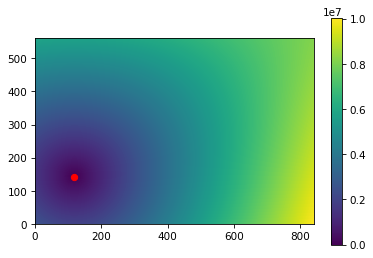

In [19]:
plt.figure(dpi=75)
plt.imshow(r, origin="lower")
plt.colorbar()
plt.plot(tc.lon_idx, tc.lat_idx,'ro') 
plt.show()

____

---

### Creating theta plot

In [20]:
def calculate_initial_compass_bearing(pointsA, pointsB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    
    lat1 = np.deg2rad(pointsA[:,0])
    lat2 = np.deg2rad(pointsB[:,0])

    diffLong = np.deg2rad(pointsB[:,1] - pointsA[:,1])

    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(diffLong))

    initial_bearing = np.arctan2(x, y)
    data = (-initial_bearing + 2.*np.pi) % (2*np.pi)
    data = (data + 0.5*np.pi) % (2*np.pi)

    return data

In [22]:
theta = calculate_initial_compass_bearing(tc_np,latlon).reshape(latlat.shape)

In [ ]:
plt.figure(dpi=300)
plt.imshow(theta, origin="lower")
plt.colorbar()
plt.plot(tc.lon_idx, tc.lat_idx,'r.') 
plt.show()

In [25]:
radial = v * np.sin(theta) + u * np.cos(theta)
tangential = v * np.cos(theta) + u * np.sin(theta)

In [107]:
def crop(array, ndims=2, ravel=False,lat_idx=tc.lat_idx, lon_idx=tc.lon_idx, dist=40):
    if ndims == 2:
        data = array[lat_idx-dist:lat_idx+dist,lon_idx-dist:lon_idx+dist]
    elif ndims == 3:
        data = array[:,lat_idx-dist:lat_idx+dist,lon_idx-dist:lon_idx+dist]
    else:
        raise (f"Dont't know how to deal with {ndims} dimensions!")
    if ravel:
        return data.ravel()
    else:
        return data

### 3D Interpolation

In [ ]:
res = (200,500,500)
clatlat = crop(np.tile(latlat,(50,1,1)))
clonlon = crop(np.tile(lonlon,(50,1,1)))
czz = crop(z)
values = crop(radial)
points = np.vstack([czz, clatlat, clonlon]).T
zgrid = np.linspace(czz.min(),czz.max(),res[0])
latgrid = np.linspace(clatlat.min(),clatlat.max(),res[1])
longrid = np.linspace(clonlon.min(),clonlon.max(),res[2])
czz, cxx, cyy= np.meshgrid(zgrid, latgrid, longrid, indexing="ij")
grid = np.vstack([czz.ravel(), cxx.ravel(), cyy.ravel()]).T
data = griddata(points, values, grid, method='linear',rescale=True).reshape(res)

### 2D Interpolation all levels

In [95]:
from tqdm import tqdm

In [268]:
interpolation_res = (1000,1000)
data = np.empty((50,*interpolation_res))
values = crop(radial, ndims=3)
clatlat = crop(latlat, ndims=2, ravel=True)
clonlon = crop(lonlon, ndims=2, ravel=True)
points = np.vstack([clatlat, clonlon]).T
latgrid = np.linspace(clatlat.min(),clatlat.max(),interpolation_res[0])
longrid = np.linspace(clonlon.min(),clonlon.max(),interpolation_res[1])
cxx, cyy= np.meshgrid(latgrid, longrid, indexing="ij")
grid = np.vstack([cxx.ravel(), cyy.ravel()]).T
for level in tqdm(range(0,50)):
    data[level,:,:] = griddata(points, values[level].ravel(), grid, method='linear',rescale=True).reshape(interpolation_res)

100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


In [269]:
mean_resolution = 1000
dr = 1000
drh = dr/2.
R = (r_e * dist.pairwise(np.deg2rad(tc_np),np.deg2rad(grid))).reshape(res)
r  = np.linspace(R.min()+dr,R.max()-dr,num=mean_resolution)

mean = np.empty((50, mean_resolution))

for level in tqdm(range(0,50)):

    image = data[level,:,:]
    f = lambda r : image[(R >= r-drh) & (R < r+drh)].mean()
    mean[level,:] = np.vectorize(f)(r)

# plot it
#fig,ax=plt.subplots()
#ax.plot(r,mean,".")
#plt.show()

100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


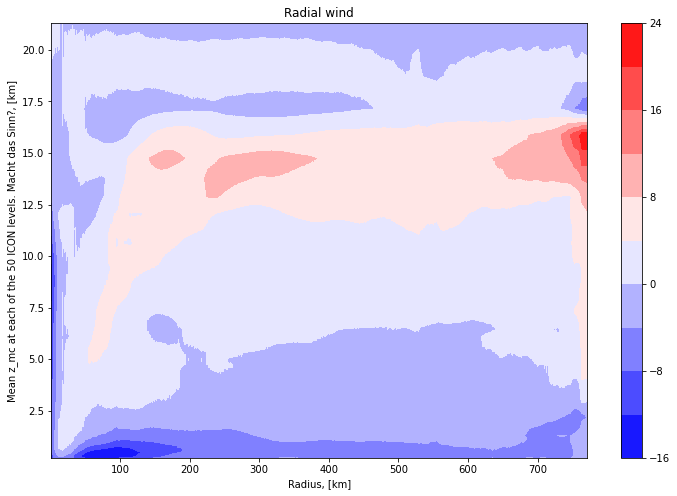

In [271]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
levels = 10#[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
cmap = 'bwr'
axf = ax.contourf(r/1000,z.mean(axis=(1,2))/1000,mean,levels=levels,cmap=cmap)
fig.colorbar(axf)
ax.set_title("Radial wind")
ax.set_xlabel("Radius, [km]")
ax.set_ylabel("Mean z_mc at each of the 50 ICON levels. Macht das Sinn?, [km]")
plt.savefig("random_tc_tangential.jpg")
#plt.axvline(x=r[ind[1]]/1000,color="k")

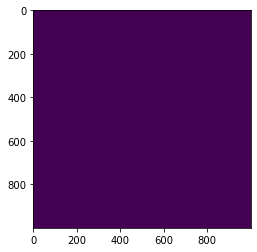

In [288]:
plt.imshow(((R >= r-0.5) & (R < r+0.5)))

In [303]:
latgrid = np.linspace(clatlat.min(),clatlat.max(),interpolation_res[0])
longrid = np.linspace(clonlon.min(),clonlon.max(),interpolation_res[1])
cxx, cyy= np.meshgrid(latgrid, longrid, indexing="ij")
grid = np.vstack([cxx.ravel(), cyy.ravel()]).T
R = (r_e * dist.pairwise(np.deg2rad(tc_np),np.deg2rad(grid))).reshape(res)
r  = np.linspace(R.min()+dr,R.max()-dr,num=300)

mask = np.empty(R.shape)
mask = False
for rad in r:
    mask += (R >= rad-1000) & (R < rad+1000)

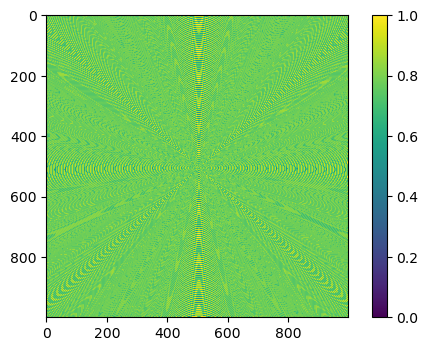

In [305]:
plt.figure(dpi=100)
plt.imshow(mask)
plt.colorbar()

In [287]:
np.sum(mask)

999998

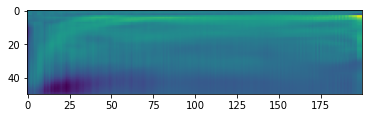

In [150]:
plt.imshow(mean)

In [155]:
z.mean(axis=(1,2)).shape

(50,)

In [185]:
meanmean = mean[:,:180].mean(axis=0)

In [187]:
ind = meanmean.argmax()

In [207]:
end = 50
ind = np.unravel_index(np.argmax(mean[:,:end], axis=None), mean[:,:end].shape)

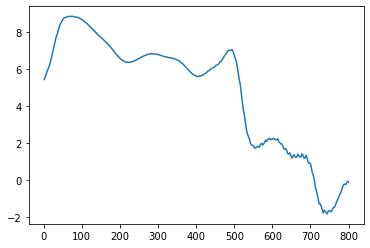

In [479]:
image = data[13,:,:]

# create array of radii
x,y = np.meshgrid(np.arange(image.shape[1]),np.arange(image.shape[0]))
R = np.sqrt(x**2+y**2)

# calculate the mean
f = lambda r : image[(R >= r-.5) & (R < r+.5)].mean()
r  = np.linspace(1,800,num=302)
mean = np.vectorize(f)(r)

# plot it
fig,ax=plt.subplots()
ax.plot(r,mean)
plt.show()

### Creating distance r plot

---

In [ ]:
latlat,lonlon= np.meshgrid(lat, lon, indexing="ij")
latlon = np.vstack([latlat.ravel(), lonlon.ravel()]).T
tc_np = np.array([tc.lat, tc.lon]).reshape((1,2))
real_r = dist.pairwise(np.deg2rad(tc_np),np.deg2rad(latlon)) * r_e
latlonreal = real_r.reshape(latlat.shape)

In [ ]:
plt.figure(dpi=75)
plt.imshow(latlonreal, origin="lower")
plt.colorbar()
plt.plot(tc.lon_idx, tc.lat_idx,'ro') 
plt.show()

____

## Doing Projection, ! Lacking negative distance actually is wrong!

In [ ]:
tc_lats = np.full(lon.shape[0], tc_np[0,0])
tc_lons = np.full(lat.shape[0], tc_np[0,1])
same_lat = np.vstack([tc_lats, lon]).T
same_lon = np.vstack([lat, tc_lons]).T
x_lon = (dist.pairwise(np.deg2rad(same_lat),np.deg2rad(tc_np)) * r_e).reshape(lon.shape)
y_lat = (dist.pairwise(np.deg2rad(same_lon),np.deg2rad(tc_np)) * r_e).reshape(lat.shape)
yy,xx= np.meshgrid(y_lat, x_lon, indexing="ij")
yx = np.vstack([yy.ravel(), xx.ravel()]).T
theta, rho = cart2pol(xx, yy)

In [ ]:
image = data.coins()
image = image[:,0:303]

# create array of radii
x,y = np.meshgrid(np.arange(image.shape[1]),np.arange(image.shape[0]))
R = np.sqrt(x**2+y**2)

# calculate the mean
f = lambda r : image[(R >= r-.5) & (R < r+.5)].mean()
r  = np.linspace(1,302,num=302)
mean = np.vectorize(f)(r)

# plot it
fig,ax=plt.subplots()
ax.plot(r,mean)
plt.show()

In [310]:
param_df.index.max()

647

In [307]:
import qgrid
param_df = pd.read_csv("./results/23_final_data_run/parameter_combinations.csv", index_col=0)
qgrid_widget = qgrid.show_grid(param_df.astype("category"))
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [ ]:
from src.plotting import plot_tc_genesis_with_density
plot_tc_genesis_with_density(df1.sort_values('date').groupby("tc_id").first(),"larger_cat_2_genesis_density.eps")

In [329]:
from sklearn.model_selection import ParameterGrid


In [351]:
tc_params = dict(
    slpdis=[25000, 50000, 100000],  # minimum distance between two slp minima
    vormin=[1e-5, 1e-6, 1e-4],  # minimum vorticity to pass as TC
    temdif=[0.75, 0.5, 1, 1.25],  # temperature difference of warm core
    temdis=[
        100000,
        200000,
        400000,
    ],  # distance at which location is considered "environment"
    winddis=[50000, 100000, 200000],  # distance within which to look for wind maximum
    maxhgt=[3000, 2500],  # maximum height where wind maximum is searched
    res=[0.125],  # resolution in degrees
)

In [352]:
old_parameter_list = ParameterGrid(tc_params)
old_parameter_list = [
    {**params, **dict(param_id=idx)}
    for idx, params in enumerate(old_parameter_list)
]

In [370]:
new_tc_params = dict(
    slpdis=[100000],  # check if there is even a difference? 100km sinnvoll fujiwara(H) oyama modell anschauen effect 2 tcs minimum distance between two slp minima
    vormin=[1e-5, 1e-6, 1e-4],  # bei denen lassen minimum vorticity to pass as TC, hat vormin überhaupt einen einfluss?, eher nicht
    temdif=[0.75, 0.5, 1, 1.25, 1.5],  # temperature difference of warm core
    temdis=[100000, 150000, 200000, 250000, 300000, 400000],# erwartung dass wenn temdis klein und temdif gross  =>  weniger #400km zu viel, überprüfe # distance at which location is considered "environment"
    winddis=[100000],  # distance within which to look for wind maximum, ist Beschreibung hat nix mit tracking zu tun, bei 100km lassen, 100 sehr sicher
    maxhgt=[3000, 2500, 2000, 1500, 1000],  # maximum height where wind maximum is searched
    res=[0.125],  # resolution in degrees
)

In [371]:
new_parameter_list = ParameterGrid(new_tc_params)
new_parameter_list = [
    {**params, **dict(param_id=idx)}
    for idx, params in enumerate(new_parameter_list)
]

In [372]:
actual_parameter_list = [params for params in new_parameter_list if not params in old_parameter_list]

In [373]:
len(actual_parameter_list)

450

In [374]:
len(new_parameter_list)

450

In [358]:
import pandas as pd

In [375]:
ndf = pd.DataFrame(new_parameter_list).drop(columns=["param_id"])

In [376]:
ndf

maxhgt    res  slpdis  temdif  temdis    vormin  winddis
0      3000  0.125  100000    0.75  100000  0.000010   100000
1      3000  0.125  100000    0.75  100000  0.000001   100000
2      3000  0.125  100000    0.75  100000  0.000100   100000
3      3000  0.125  100000    0.75  150000  0.000010   100000
4      3000  0.125  100000    0.75  150000  0.000001   100000
..      ...    ...     ...     ...     ...       ...      ...
445    1000  0.125  100000    1.50  300000  0.000001   100000
446    1000  0.125  100000    1.50  300000  0.000100   100000
447    1000  0.125  100000    1.50  400000  0.000010   100000
448    1000  0.125  100000    1.50  400000  0.000001   100000
449    1000  0.125  100000    1.50  400000  0.000100   100000

[450 rows x 7 columns]

In [377]:
odf = pd.DataFrame(old_parameter_list).drop(columns=["param_id"])
odf

maxhgt    res  slpdis  temdif  temdis    vormin  winddis
0      3000  0.125   25000    0.75  100000  0.000010    50000
1      3000  0.125   25000    0.75  100000  0.000010   100000
2      3000  0.125   25000    0.75  100000  0.000010   200000
3      3000  0.125   25000    0.75  100000  0.000001    50000
4      3000  0.125   25000    0.75  100000  0.000001   100000
..      ...    ...     ...     ...     ...       ...      ...
643    2500  0.125  100000    1.25  400000  0.000001   100000
644    2500  0.125  100000    1.25  400000  0.000001   200000
645    2500  0.125  100000    1.25  400000  0.000100    50000
646    2500  0.125  100000    1.25  400000  0.000100   100000
647    2500  0.125  100000    1.25  400000  0.000100   200000

[648 rows x 7 columns]

In [381]:
adf = pd.concat([ndf, odf, odf]).drop_duplicates(keep=False)
adf

maxhgt    res  slpdis  temdif  temdis    vormin  winddis
3      3000  0.125  100000    0.75  150000  0.000010   100000
4      3000  0.125  100000    0.75  150000  0.000001   100000
5      3000  0.125  100000    0.75  150000  0.000100   100000
9      3000  0.125  100000    0.75  250000  0.000010   100000
10     3000  0.125  100000    0.75  250000  0.000001   100000
..      ...    ...     ...     ...     ...       ...      ...
445    1000  0.125  100000    1.50  300000  0.000001   100000
446    1000  0.125  100000    1.50  300000  0.000100   100000
447    1000  0.125  100000    1.50  400000  0.000010   100000
448    1000  0.125  100000    1.50  400000  0.000001   100000
449    1000  0.125  100000    1.50  400000  0.000100   100000

[378 rows x 7 columns]

In [379]:
aadf = ndf.loc[~ndf.set_index(list(ndf.columns)).index.isin(odf.set_index(list(odf.columns)).index)]

In [380]:
aadf

maxhgt    res  slpdis  temdif  temdis    vormin  winddis
3      3000  0.125  100000    0.75  150000  0.000010   100000
4      3000  0.125  100000    0.75  150000  0.000001   100000
5      3000  0.125  100000    0.75  150000  0.000100   100000
9      3000  0.125  100000    0.75  250000  0.000010   100000
10     3000  0.125  100000    0.75  250000  0.000001   100000
..      ...    ...     ...     ...     ...       ...      ...
445    1000  0.125  100000    1.50  300000  0.000001   100000
446    1000  0.125  100000    1.50  300000  0.000100   100000
447    1000  0.125  100000    1.50  400000  0.000010   100000
448    1000  0.125  100000    1.50  400000  0.000001   100000
449    1000  0.125  100000    1.50  400000  0.000100   100000

[378 rows x 7 columns]

In [386]:
new_params = adf.to_dict("records")

In [387]:
new_params = [
    {**params, **dict(param_id=idx+648)}
    for idx, params in enumerate(new_params)
]

In [390]:
import pickle
import json

In [397]:
with open('outputfile.json', 'w') as fout:
    json.dump(new_params, fout)

In [398]:
with open('outputfile.json') as fin:
    json_params = json.load(fin)


In [399]:
json_params

[{'maxhgt': 3000,
  'res': 0.125,
  'slpdis': 100000,
  'temdif': 0.75,
  'temdis': 150000,
  'vormin': 1e-05,
  'winddis': 100000,
  'param_id': 648},
 {'maxhgt': 3000,
  'res': 0.125,
  'slpdis': 100000,
  'temdif': 0.75,
  'temdis': 150000,
  'vormin': 1e-06,
  'winddis': 100000,
  'param_id': 649},
 {'maxhgt': 3000,
  'res': 0.125,
  'slpdis': 100000,
  'temdif': 0.75,
  'temdis': 150000,
  'vormin': 0.0001,
  'winddis': 100000,
  'param_id': 650},
 {'maxhgt': 3000,
  'res': 0.125,
  'slpdis': 100000,
  'temdif': 0.75,
  'temdis': 250000,
  'vormin': 1e-05,
  'winddis': 100000,
  'param_id': 651},
 {'maxhgt': 3000,
  'res': 0.125,
  'slpdis': 100000,
  'temdif': 0.75,
  'temdis': 250000,
  'vormin': 1e-06,
  'winddis': 100000,
  'param_id': 652},
 {'maxhgt': 3000,
  'res': 0.125,
  'slpdis': 100000,
  'temdif': 0.75,
  'temdis': 250000,
  'vormin': 0.0001,
  'winddis': 100000,
  'param_id': 653},
 {'maxhgt': 3000,
  'res': 0.125,
  'slpdis': 100000,
  'temdif': 0.75,
  'temdis': 30

In [10]:
import os
import netCDF4
import pandas as pd
from src.utils import str_to_datetime, datetime_to_str

In [5]:
sim_base_dir = "/wolke_scratch/enzb/ICON/output/sim_13k_largedomain"

sim_params = dict(
    initime="2013-06-01T000000Z",
    endtime="2013-12-01T000000Z",
    inbase="REMAP_NWP_LAM_DOM01_",
    inbase2="REMAP_NWP_LAM_PL_T_DOM01_",
)

In [11]:
curr_datetime = str_to_datetime(sim_params["initime"])
end_datetime = str_to_datetime(sim_params["endtime"])

date_range = (
    pd.date_range(start=curr_datetime, end=end_datetime, freq="6h")
    .to_pydatetime()
    .tolist()
)

In [43]:
from tqdm import tqdm
from tqdm.notebook import trange, tqdm


In [45]:
experiments = ("ref", "rm")
members = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]
n_all_iterations = len(experiments) * len(members) * len(date_range)
with tqdm(total=n_all_iterations) as t:

    for exp in experiments:
        for mem in members:
            indir = f"{sim_base_dir}/2013_{mem}_{exp}/remap/"
            for curr_datetime in date_range:
                fname2 = os.path.join(indir, sim_params["inbase2"] + datetime_to_str(curr_datetime) + ".nc")
                dataset2 = netCDF4.Dataset(fname2)
                try:
                    test[datetime_to_str(curr_datetime)] = dataset2.variables["temp"][0, 0, :, :]
                except:
                    print(exp, mem, curr_datetime)
                dataset2.close()

  0%|          | 0/14660 [00:00<?, ?it/s]

ref 03 2013-06-01 00:00:00


  0%|          | 0/14660 [03:45<?, ?it/s]


In [40]:
test = {}
curr_datetime = date_range[2]
print(curr_datetime)
fname2 = os.path.join(indir, sim_params["inbase2"] + datetime_to_str(curr_datetime) + ".nc")
dataset2 = netCDF4.Dataset(fname2)


2013-06-01 12:00:00


In [41]:
dataset2.variables["temp"]

<class 'netCDF4._netCDF4.Variable'>
float32 temp(time, plev, lat, lon)
    standard_name: air_temperature
    long_name: Temperature
    units: K
    param: 0.0.0
    _FillValue: -9.99e-08
    missing_value: -9.99e-08
unlimited dimensions: time
current shape = (1, 1, 561, 841)
filling on

In [ ]:
fname2 = os.path.join(
        sim_params["indir2"],
        sim_params["inbase2"] + datetime_to_str(curr_datetime) + ".nc",
    )
dataset2 = netCDF4.Dataset(fname2)
    tc_data["tem"] = dataset2.variables["temp"][0, 0, :, :]
    dataset2.close()